## 5.Find valuable users by applying RFM theory

RFM (recency, frequency, monetary) analysis is a marketing technique used to determine quantitatively which customers are the best ones by examining how recently a customer has purchased (recency), how often they purchase (frequency), and how much the customer spends (monetary).

In [1]:
import pandas as pd
import numpy as np
from IPython.display import Image

In [2]:
users = pd.read_csv('/Users/paxton615/Github_Personal/\
Alibaba_UserBehavior_Analysis/drafts/users_2m.csv')
users.drop('Unnamed: 0', axis=1, inplace=True)
users.head()

,user_id,item_id,category_id,status,date,dayofweek,hour
0,309818,4710383,1792277,pv,2017-11-29,2,20
1,309818,1421743,4069500,pv,2017-11-29,2,20
2,309818,800137,1216617,pv,2017-11-29,2,20
3,309818,2493122,1216617,pv,2017-11-29,2,20
4,309818,1461532,3102419,pv,2017-11-30,3,7


#### How recent does each user shop

In [8]:
# the most recent shopping record of each user
recent_shopping = users[users['status']=='buy']\
.groupby('user_id',as_index=False)['date'].agg(['max'])
recent_shopping.columns=['recent_shopping']
recent_shopping.reset_index(inplace=True)
recent_shopping.head()

,user_id,recent_shopping
0,43,2017-12-03
1,310,2017-12-01
2,311,2017-12-03
3,312,2017-12-03
4,318,2017-11-30


In [10]:
np.sort(recent_shopping['recent_shopping'].unique())

array(['2017-11-25', '2017-11-26', '2017-11-27', '2017-11-28',
       '2017-11-29', '2017-11-30', '2017-12-01', '2017-12-02',
       '2017-12-03'], dtype=object)

In [12]:
# rank each user from 0-2, the most recent the higher.

recent_shopping['R'] = [0 if '2017-11-25'<= i <='2017-11-27' 
                   else 1 if '2017-11-28' <= i <= '2017-11-30' 
                   else 2 for i in recent_shopping.recent_shopping]

In [13]:
recent_shopping.head()

,user_id,recent_shopping,R
0,43,2017-12-03,2
1,310,2017-12-01,2
2,311,2017-12-03,2
3,312,2017-12-03,2
4,318,2017-11-30,1


#### How often does each user shop

In [14]:
shopping_lots = users[users['status']=='buy'].groupby('user_id', as_index=False).item_id.count()

shopping_lots.head()

,user_id,item_id
0,43,6
1,310,1
2,311,9
3,312,8
4,318,2


In [15]:
np.sort(shopping_lots.item_id.unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 35, 36,
       39, 40, 43, 45, 92])

In [16]:
# rate users based on their shopping lots
shopping_lots['F'] = [ 5 if i >= 50 
                     else 4 if 49 >= i >= 40
                     else 3 if 39 >= i >= 30
                     else 2 if 29 >= i >= 20
                     else 1 for i in shopping_lots.item_id]


In [17]:
shopping_lots.head()

,user_id,item_id,F
0,43,6,1
1,310,1,1
2,311,9,1
3,312,8,1
4,318,2,1


#### Calculating RMF

In [20]:
rmf = pd.merge(recent_shopping, shopping_lots, on='user_id')\
[['user_id','recent_shopping','R','F']]
rmf['R+F'] = rmf['R']+rmf['F']
rmf.head()

,user_id,recent_shopping,R,F,R+F
0,43,2017-12-03,2,1,3
1,310,2017-12-01,2,1,3
2,311,2017-12-03,2,1,3
3,312,2017-12-03,2,1,3
4,318,2017-11-30,1,1,2


In [49]:
pd.DataFrame(rmf['R+F'].value_counts(normalize=True)).index

Int64Index([3, 2, 1, 4, 5, 6, 7], dtype='int64')

In [75]:
list(pd.DataFrame(rmf['R+F'].value_counts())['R+F'])

[11495, 5265, 3060, 34, 7, 3, 1]

In [67]:
from pyecharts import options as opts
from pyecharts.charts import Bar
from IPython.display import IFrame
c = (
    Bar(init_opts=opts.InitOpts(width="600px", height="300px"))
    .add_xaxis([3, 2, 1, 4, 5, 6, 7])
    .add_yaxis("Users", [0.578656, 0.265039, 0.15404, 0.001712, 0.000352, 0.000151, 5e-05])
    .set_global_opts(
        title_opts=opts.TitleOpts(title="User Rankings (%)"),
        legend_opts=opts.LegendOpts(is_show=False),
    )
    .render("bar_toolbox.html")
)
IFrame(src='./bar_toolbox.html', width=600, height=300)

In [76]:
from pyecharts import options as opts
from pyecharts.charts import Bar
from IPython.display import IFrame
c = (
    Bar(init_opts=opts.InitOpts(width="600px", height="300px"))
    .add_xaxis([3, 2, 1, 4, 5, 6, 7])
    .add_yaxis("Users", [11495, 5265, 3060, 34, 7, 3, 1])
    .set_global_opts(
        title_opts=opts.TitleOpts(title="User Rankings"),
        legend_opts=opts.LegendOpts(is_show=False),
    )
    .render("bar_toolbox.html")
)
IFrame(src='./bar_toolbox.html', width=600, height=300)

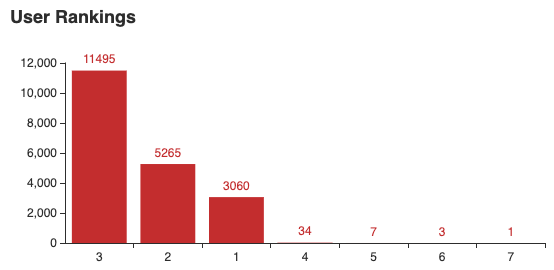

In [81]:
Image(filename='/Users/paxton615/Github_Personal/Alibaba_UserBehavior_Analysis/pics/user_rankings.png')

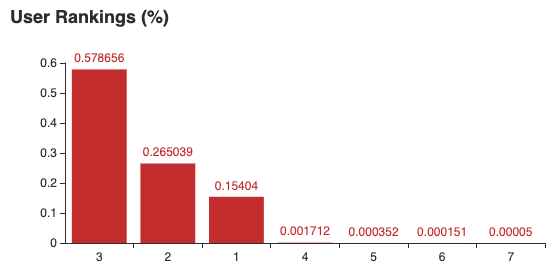

In [82]:
Image(filename='/Users/paxton615/Github_Personal/Alibaba_UserBehavior_Analysis/pics/user_rankings_percent.png')

#### As we can see from these two charts, top ranking users whoes numbers are beyond 3 are rare.
#### majority users are rated 3

In [89]:
majority = rmf[rmf['R+F']==3]

In [102]:
print('The total number of users shopped in 11.25-11.27 is {}'.format(len(majority[majority['R']==0])))
print('The total number of users shopped in 11.28-11.30 is {}'.format(len(majority[majority['R']==1])))
print('The total number of users shopped in 12.1-12.3 is {}'.format(len(majority[majority['R']==2])))

The total number of users shopped in 11.25-11.27 is 0
The total number of users shopped in 11.28-11.30 is 4
The total number of users shopped in 12.1-12.3 is 11491


#### The results indicate that almost 58% users had shopping record within 12.1-12.3. And each of them bought no more than 20 items or less within the period. 